In [1]:
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags
import numpy as np
from util.models import MODELS
from util.tasks import TASKS

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

from tqdm import tqdm

In [2]:
student_exp_name='lisa_fd7'
teacher_exp_name='0.001_lisa_offlineteacher_v1'
teacher_config='lstm_drop31_v2'
task_name = 'word_sv_agreement_lm'
student_model='lm_gpt2'
teacher_model='lm_lstm_shared_emb'
student_config='very_big_gpt_v10'
distill_config='pure_distill_4'
distill_mode='offline'

chkpt_dir='../tf_ckpts'

In [3]:
task = TASKS[task_name](get_task_params(), data_dir='../data')

Vocab len:  10034


In [4]:
cl_token = task.databuilder.sentence_encoder().encode(constants.bos)
teacher_model = MODELS[teacher_model](hparams=get_model_params(task, teacher_model, teacher_config), cl_token=cl_token)
std_hparams=get_model_params(task, student_model, student_config)
std_hparams.output_attentions = True
std_hparams.output_embeddings = True
student_model = MODELS[student_model](
std_hparams, cl_token=cl_token)

model config: lstm_drop31_v2
{'hidden_dim': 512, 'embedding_dim': 512, 'depth': 2, 'hidden_dropout_rate': 0.3, 'input_dropout_rate': 0.2}
model config: very_big_gpt_v10
{'embedding_dim': 512, 'resid_pdrop': 0.4, 'embd_pdrop': 0.2, 'attn_pdrop': 0.6, 'initializer_range': 0.05}


In [5]:
student_ckpt_dir = os.path.join(chkpt_dir, task.name,
                              '_'.join([distill_mode,distill_config,
                                        "teacher", teacher_model.model_name, 
                                        #teacher_config,
                                        teacher_exp_name,
                                       "student",student_model.model_name,
                                        str(student_config),
                                        student_exp_name]))
print("student_checkpoint:", student_ckpt_dir)

student_ckpt = tf.train.Checkpoint(net=student_model)
student_manager = tf.train.CheckpointManager(student_ckpt, student_ckpt_dir, max_to_keep=None)

student_ckpt.restore(student_manager.latest_checkpoint)
if student_manager.latest_checkpoint:
  print("Restored student from {}".format(student_manager.latest_checkpoint))

student_model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
student_model.evaluate(task.test_dataset, steps=100)

student_checkpoint: ../tf_ckpts/word_sv_agreement_lm/offline_pure_distill_4_teacher_lm_lstm_shared_emb_em-512_h-512_d-2_hdrop-0.3_indrop-0.2_0.001_lisa_offlineteacher_v1_student_lm_gpt2_h-512_d-6_rdrop-0.4_adrop-0.6_indrop-0.2_very_big_gpt_v10_lisa_fd7
Restored student from ../tf_ckpts/word_sv_agreement_lm/offline_pure_distill_4_teacher_lm_lstm_shared_emb_em-512_h-512_d-2_hdrop-0.3_indrop-0.2_0.001_lisa_offlineteacher_v1_student_lm_gpt2_h-512_d-6_rdrop-0.4_adrop-0.6_indrop-0.2_very_big_gpt_v10_lisa_fd7/ckpt-60


  1/100 [..............................] - ETA: 7:30:28

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node loss/h_._1/mlp/c_fc/bias/Regularizer/Square (defined at /home/samira/anaconda3/envs/indist/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/batch_masked_sequence_loss/batch_masked_sequence_loss/StatefulPartitionedCall/loss/assert_equal/Assert/Assert/_101]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node loss/h_._1/mlp/c_fc/bias/Regularizer/Square (defined at /home/samira/anaconda3/envs/indist/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_9011]

Function call stack:
distributed_function -> distributed_function


In [ ]:
teacher_ckpt_dir = os.path.join(chkpt_dir, task.name,
                                  '_'.join([teacher_model.model_name, teacher_config,teacher_exp_name]))

teacher_ckpt = tf.train.Checkpoint(net=teacher_model)
teacher_manager = tf.train.CheckpointManager(teacher_ckpt, teacher_ckpt_dir, max_to_keep=None)

teacher_ckpt.restore(teacher_manager.latest_checkpoint)
if teacher_manager.latest_checkpoint:
  print("Restored student from {}".format(teacher_manager.latest_checkpoint))

teacher_model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
teacher_model.evaluate(task.test_dataset, steps=100)

In [ ]:
model_name='lm_gpt2'
model_config='very_big_gpt_v10'
learning_rate=0.0001
exp_name='offlineteacher_v1'

cl_token = task.databuilder.sentence_encoder().encode(constants.bos)
hparams=get_model_params(task, model_name, model_config)
hparams.output_attentions = True
hparams.output_embeddings = True

model = MODELS[model_name](hparams=hparams, cl_token=cl_token)


ckpt_dir = os.path.join(chkpt_dir,task.name,
                        model.model_name+"_"+str(model_config)+"_"+str(learning_rate)+"_"+exp_name)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

In [94]:
def test_for_calibration(model, task):
    preds = []
    probs = []
    y_trues = []
    batch_count = task.n_valid_batches
    padding_symbol=0
    for x, y in task.valid_dataset:
        logits = model(x)
        pred = tf.argmax(logits, axis=-1)
        prob = task.get_probs_fn()(logits, labels=y, temperature=1)
        preds.extend(pred.numpy())
        y_trues.extend(y.numpy())
        batch_indexes = tf.range(len(y), dtype=tf.int64)
        indexes = tf.concat([batch_indexes[:,None], y[:,None]], axis=1)
        probs.extend(tf.gather_nd(prob, indexes).numpy())
        batch_count -= 1
        if batch_count == 0:
            break

    model_accuracy = np.asarray(preds) == np.asarray(y_trues)

    p_confidence_bins = np.zeros(10)
    n_confidence_bins = np.zeros(10)
    for i in np.arange(len(model_accuracy)):
        if model_accuracy[i]:
            p_confidence_bins[int(probs[i]*100 / 10)] += 1
        else:
            n_confidence_bins[int(probs[i]*100 / 10)] -= 1

    sns.scatterplot(model_accuracy,probs)
    plt.show()
    sns.barplot(x=np.arange(9)*10, y=p_confidence_bins[:9], color='blue', saturation=0.3)
    sns.barplot(x=np.arange(9)*10, y=n_confidence_bins[:9], color='red', saturation=0.3)
    plt.show()

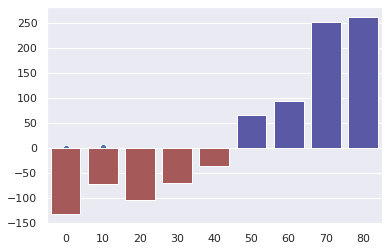

In [86]:
test_for_calibration(teacher_model, task)

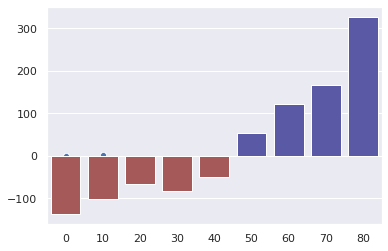

In [87]:
test_for_calibration(student_model, task)

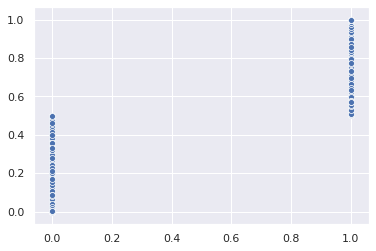

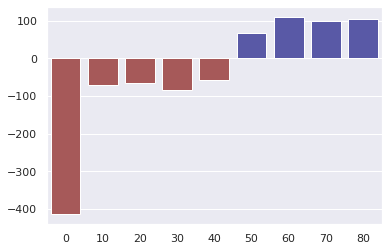

In [95]:
test_for_calibration(model, task)